In [1]:
%load_ext autoreload
%autoreload 2
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import sys
sys.path.insert(0, "../scripts/trimap_generation/")
sys.path.insert(0, "../scripts/")
from saliency import get_saliency_fine_grained
import cv2 as cv
from matplotlib.pyplot import imshow
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from trimap import generate_trimap
import tensorflow as tf
from scipy import misc


In [2]:
base = "C:\\Workspace\\SalienceModel\\Salient-Object-Detection\\"

In [30]:
img = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\16452523375_08591714cf_o_0.jpg"

In [3]:
g_mean = np.array(([126.88,120.24,112.19])).reshape([1,1,3])


In [31]:
def tryit():
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 1)
    with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
        saver = tf.train.import_meta_graph(base + 'meta_graph\my-model.meta')
        saver.restore(sess,tf.train.latest_checkpoint(base + 'salience_model'))
        image_batch = tf.get_collection('image_batch')[0]
        pred_mattes = tf.get_collection('mask')[0]

        rgb = misc.imread(img)
        origin_shape = rgb.shape[:2]

        rgb = np.expand_dims(misc.imresize(rgb.astype(np.uint8),[320,320,3],interp="nearest").astype(np.float32)-g_mean,0)
        feed_dict = {image_batch:rgb}
        pred_alpha = sess.run(pred_mattes,feed_dict = feed_dict)
        final_alpha = misc.imresize(np.squeeze(pred_alpha),origin_shape)
        return final_alpha


In [32]:
alpha = tryit()

INFO:tensorflow:Restoring parameters from C:\Workspace\SalienceModel\Salient-Object-Detection\salience_model\model.ckpt-200


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


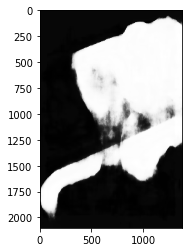

In [33]:
imshow(alpha, cmap="gray")

In [13]:
ret2,th2 = cv.threshold(alpha,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

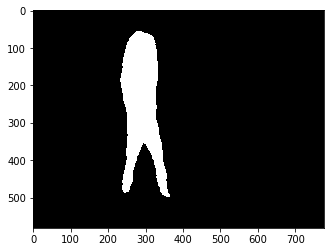

In [14]:
imshow(th2, cmap="gray")

In [16]:
def trimap_gen(im):
    kernel_erosion = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))
    kernel_dilation = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    dilated = cv.dilate(im, kernel_dilation, iterations=10)
    eroded = cv.erode(im, kernel_erosion, iterations=10)
    unknown = dilated - eroded
    print(np.unique(eroded))
    return eroded + unknown * (128 / 255)

[  0 255]


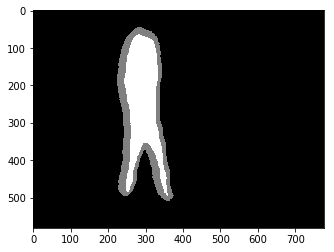

In [17]:
imshow(trimap_gen(th2), cmap="gray")

In [18]:
saliency = get_saliency_fine_grained(cv.imread("../images/person.jpg"))

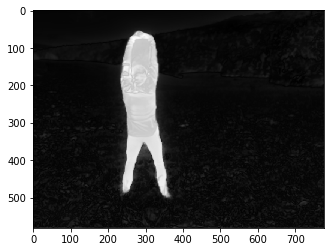

In [25]:
imshow((saliency*255) * 0.25 + alpha * 0.75, cmap="gray")

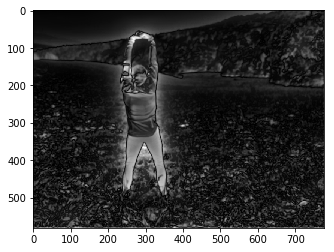

In [23]:
imshow(saliency*255, cmap="gray")